In [1]:
import os
import glob
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from sklearn.decomposition import PCA
import tqdm
import xarray as xr
import rioxarray as rxr
import planetary_computer
import pystac_client
from pystac_client import Client
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import mapping, shape, MultiPolygon, Point, Polygon, box

import dask
import dask.array as da
import dask.delayed

In [2]:
admin_boundaries_gdf = gpd.read_file("./2016_phc_vut_pid_4326.geojson")
#admin_boundaries_gdf = admin_boundaries_gdf.set_index(keys="pname")  # set province name as the index

In [3]:
admin_boundaries_gdf

,pid,pname,geometry
0,1,TORBA,"MULTIPOLYGON (((168.03896 -14.48033, 168.03885..."
1,2,SANMA,"MULTIPOLYGON (((167.25572 -15.71481, 167.25582..."
2,3,PENAMA,"MULTIPOLYGON (((168.2481 -15.78748, 168.24811 ..."
3,4,MALAMPA,"MULTIPOLYGON (((167.48039 -16.60241, 167.47951..."
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."
5,6,TAFEA,"MULTIPOLYGON (((169.84994 -20.25396, 169.85015..."


In [40]:
PROVINCE = "SHEFA"
DATERANGE_START = "2025-04-01"
DATERANGE_END = "2025-08-01"

In [41]:
admin_boundaries_gdf.columns

Index(['pid', 'pname', 'geometry'], dtype='object')

In [42]:
# Filter to one province (e.g., SHEFA)
#admin_boundaries_gdf = admin_boundaries_gdf.to_crs("EPSG:32759")
province_match = admin_boundaries_gdf[admin_boundaries_gdf["pname"] == PROVINCE]

In [43]:
province_match

,pid,pname,geometry
4,5,SHEFA,"MULTIPOLYGON (((168.30762 -17.77548, 168.30773..."


In [44]:
province_match.geometry

4    MULTIPOLYGON (((168.30762 -17.77548, 168.30773...
Name: geometry, dtype: geometry

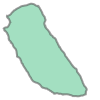

In [61]:
mp = province_match.loc[4, "geometry"]

if isinstance(mp, MultiPolygon):
    # Sort polygons by area
    polys_sorted = sorted(mp.geoms, key=lambda p: p.area)

    if len(polys_sorted) >= 3:
        #selected = polys_sorted[len(polys_sorted) // 2]
        selected = polys_sorted[-5]
    elif len(polys_sorted) == 2:
        # For just two, pick the larger or smaller depending on definition
        selected = polys_sorted[0]  # or polys_sorted[1]
    else:
        selected = polys_sorted[0]  # Only one polygon

else:
    selected = mp  # Already a single polygon

selected

In [62]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"
stac_client = Client.open(aws_stac_url)

In [63]:
# Search Sentinel-2 data on AWS with cloud cover less than 20%
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"],
    bbox=selected.bounds,
    datetime=f"{DATERANGE_START}/{DATERANGE_END}", 
    query={"eo:cloud_cover": {"lt": 50}}  # Filter by cloud cover < 20%
)

In [64]:
# Retrieve all items from search results
s2_items = s2_search.item_collection()

In [65]:
len(s2_items)

48

In [66]:
s2_data = odc.stac.load(
    items=s2_items,
    bands=["red", "green", "blue", "nir", "swir16", "scl"],
    bbox=selected.bounds,
    crs="EPSG:32759", #"EPSG:32759",
    chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
    resolution=30
)

In [67]:
bands = ['red', 'green', 'blue', 'nir', 'swir16']

In [68]:
cloud_classes = [3, 8, 9, 10]  # Cloud-related SCL classes
cloud_mask = s2_data['scl'].isin(cloud_classes)
s2_data_masked = s2_data[bands].where(~cloud_mask, drop=False)  # Keep all pixels

In [69]:
# Average across the time dimension
s2_data_composite = s2_data_masked.median(dim='time')

In [70]:
s2_data_composite

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 273, x: 237)
Coordinates:
  * y            (y) float64 2kB 8.073e+06 8.073e+06 ... 8.065e+06 8.065e+06
  * x            (x) float64 2kB 2.156e+05 2.156e+05 ... 2.226e+05 2.227e+05
    spatial_ref  int32 4B 32759
Data variables:
    red          (y, x) float32 259kB dask.array<chunksize=(273, 237), meta=np.ndarray>
    green        (y, x) float32 259kB dask.array<chunksize=(273, 237), meta=np.ndarray>
    blue         (y, x) float32 259kB dask.array<chunksize=(273, 237), meta=np.ndarray>
    nir          (y, x) float32 259kB dask.array<chunksize=(273, 237), meta=np.ndarray>
    swir16       (y, x) float32 259kB dask.array<chunksize=(273, 237), meta=np.ndarray>

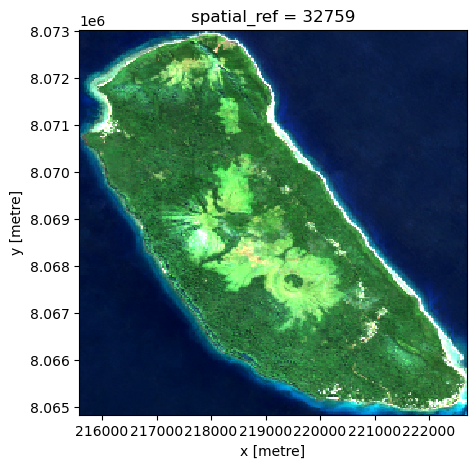

In [71]:
s2_data_composite[["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=1)

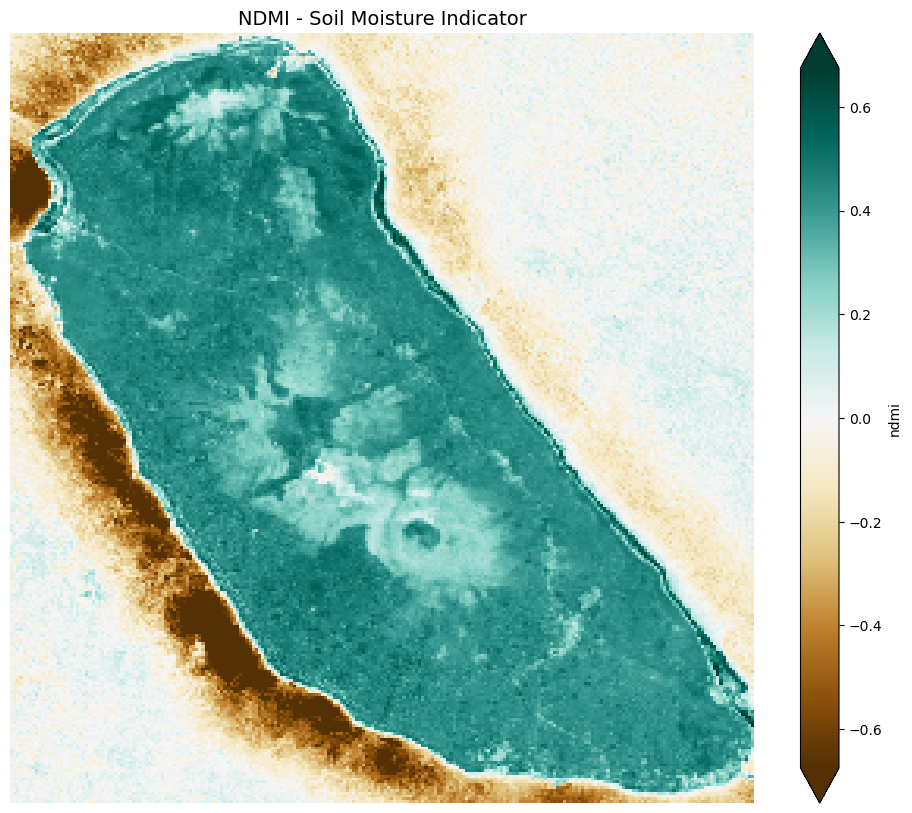

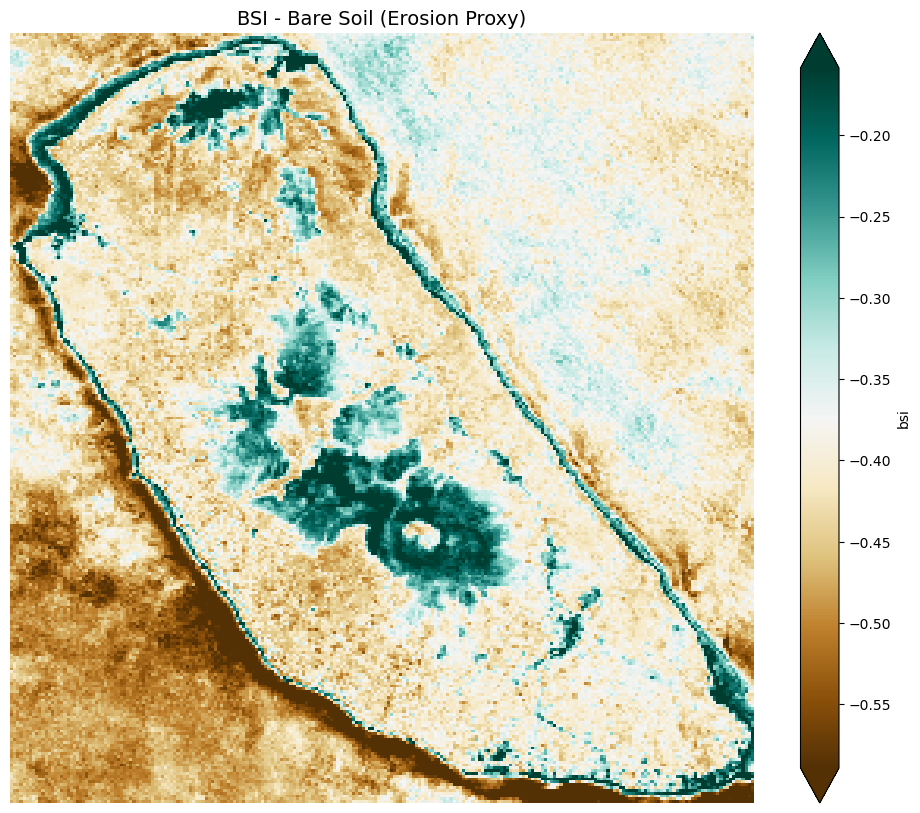

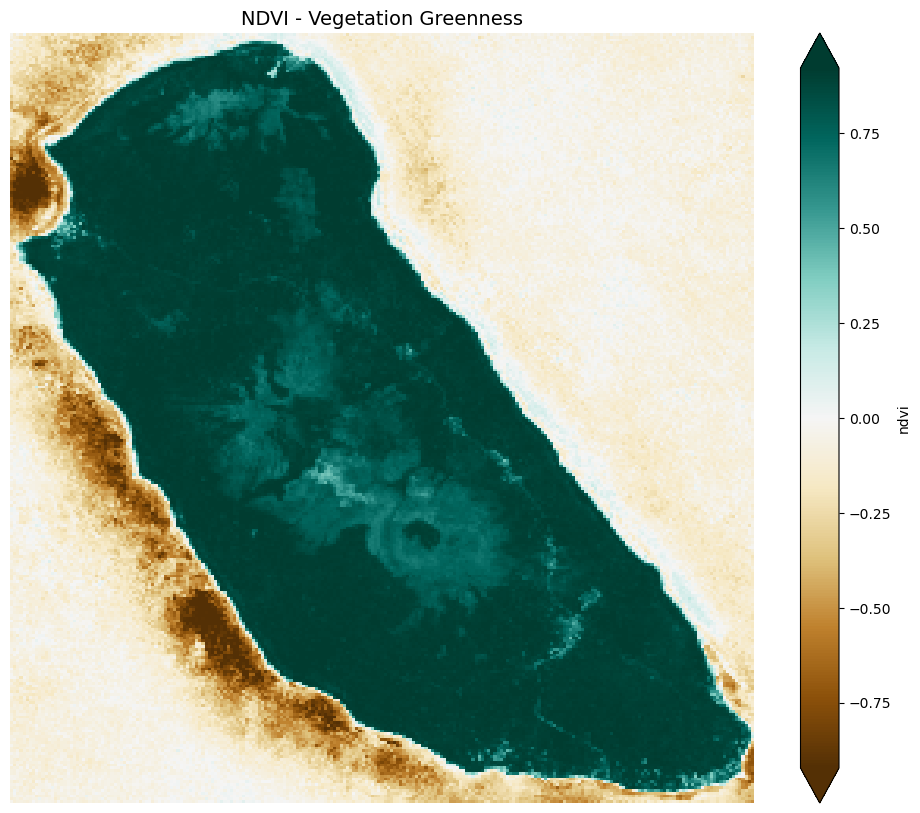

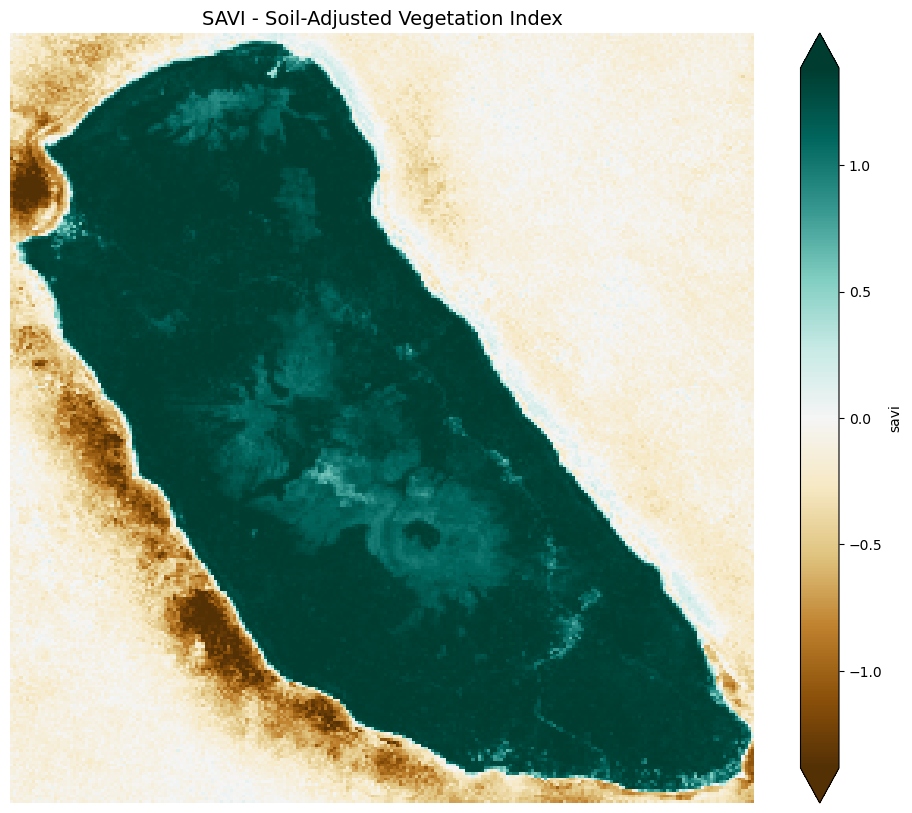

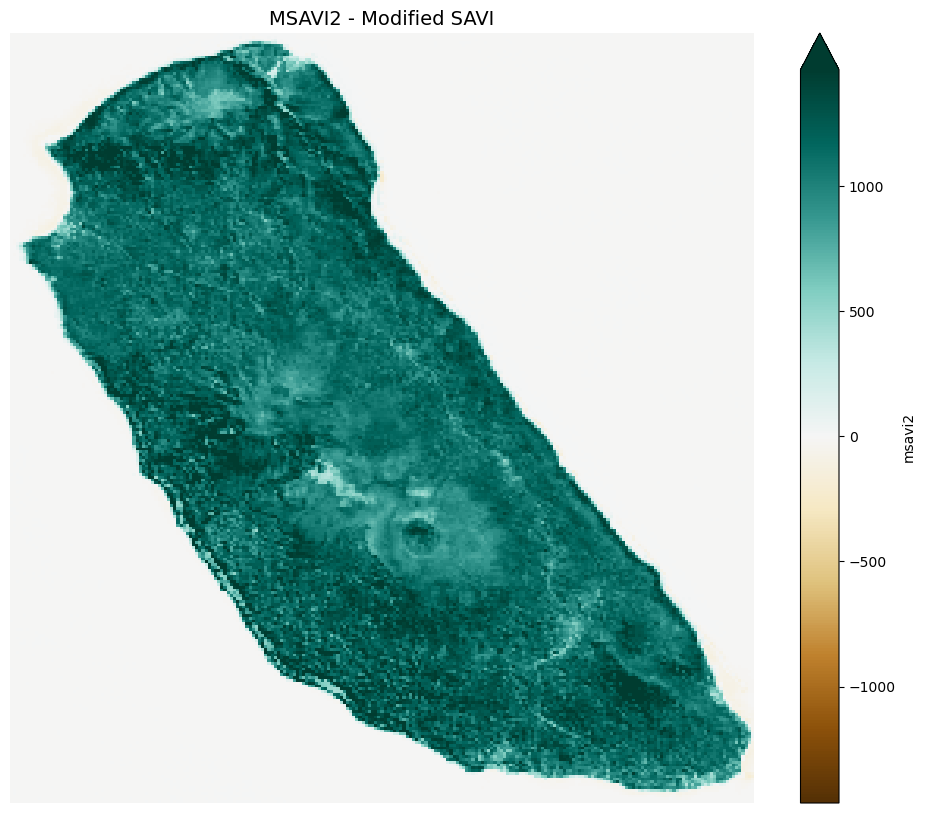

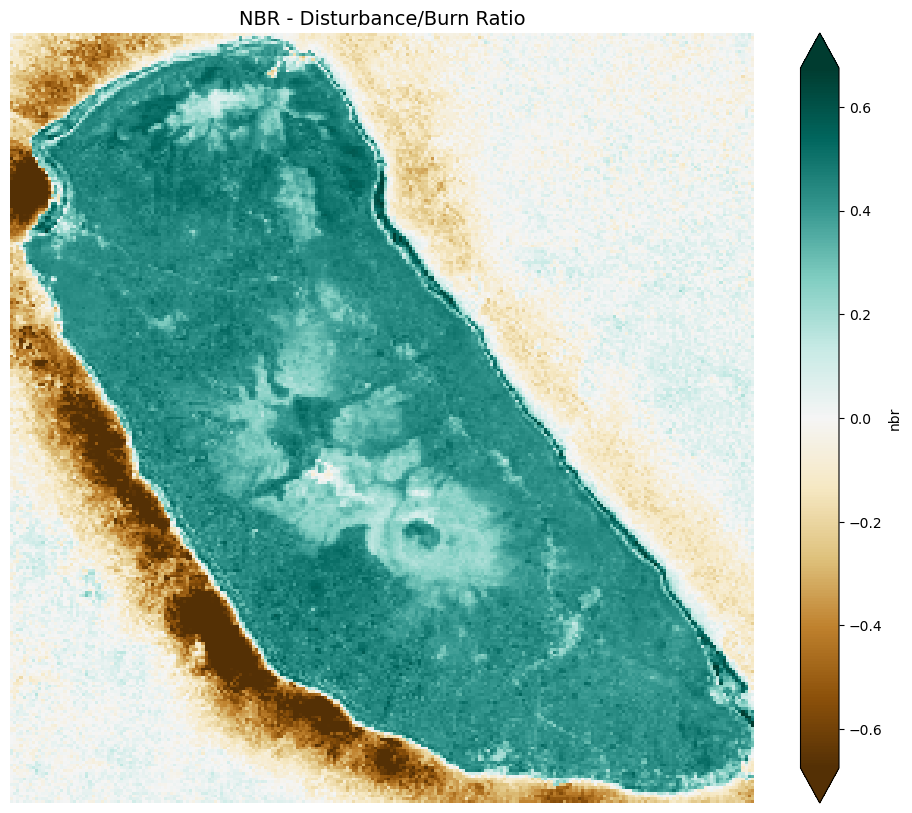

In [72]:
def compute_ndmi(nir, swir):
    """
    Compute the Normalized Difference Moisture Index (NDMI).

    NDMI measures vegetation and soil moisture by comparing near-infrared (NIR) and short-wave infrared (SWIR) reflectance.

    Formula:
        NDMI = (NIR - SWIR) / (NIR + SWIR)

    Parameters
    ----------
    nir : xarray.DataArray
        Near-infrared reflectance band.
    swir : xarray.DataArray
        Short-wave infrared reflectance band.

    Returns
    -------
    xarray.DataArray
        NDMI values for each pixel.
    """
    return (nir - swir) / (nir + swir)


def compute_bsi(blue, red, nir, swir):
    """
    Compute the Bare Soil Index (BSI).

    BSI identifies bare or sparsely vegetated soil areas, which can indicate erosion or degraded land.

    Formula:
        BSI = ((SWIR + Red) - (NIR + Blue)) / ((SWIR + Red) + (NIR + Blue))

    Parameters
    ----------
    blue : xarray.DataArray
        Blue band reflectance.
    red : xarray.DataArray
        Red band reflectance.
    nir : xarray.DataArray
        Near-infrared reflectance band.
    swir : xarray.DataArray
        Short-wave infrared reflectance band.

    Returns
    -------
    xarray.DataArray
        BSI values for each pixel.
    """
    return ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))


def ndvi(red, nir):
    """
    Compute the Normalized Difference Vegetation Index (NDVI).

    NDVI measures vegetation greenness and health. 
    NDVI gives vegetation cover health (proxy for root activity, biomass and reduced erosion). 

    Formula:
        NDVI = (NIR - Red) / (NIR + Red)

    Parameters
    ----------
    red : xarray.DataArray
        Red band reflectance.
    nir : xarray.DataArray
        Near-infrared reflectance band.

    Returns
    -------
    xarray.DataArray
        NDVI values for each pixel.
    """
    return (nir - red) / (nir + red)


def savi(red, nir, L=0.5):
    """
    Compute the Soil-Adjusted Vegetation Index (SAVI).

    SAVI adjusts NDVI to minimize soil brightness effects, useful in sparse vegetation areas.

    Formula:
        SAVI = ((NIR - Red) * (1 + L)) / (NIR + Red + L)

    Parameters
    ----------
    red : xarray.DataArray
        Red band reflectance.
    nir : xarray.DataArray
        Near-infrared reflectance band.
    L : float, optional
        Soil adjustment factor (default 0.5 for intermediate vegetation cover).

    Returns
    -------
    xarray.DataArray
        SAVI values for each pixel.
    """
    return ((nir - red) * (1 + L)) / (nir + red + L)


def msavi2(red, nir):
    """
    Compute the Modified Soil-Adjusted Vegetation Index 2 (MSAVI2).

    MSAVI2 improves vegetation detection in areas with significant bare soil by removing the need for a soil adjustment factor.

    Formula:
        MSAVI2 = [2 * NIR + 1 - sqrt((2 * NIR + 1)^2 - 8 * (NIR - Red))] / 2

    Parameters
    ----------
    red : xarray.DataArray
        Red band reflectance.
    nir : xarray.DataArray
        Near-infrared reflectance band.

    Returns
    -------
    xarray.DataArray
        MSAVI2 values for each pixel.
    """
    a = 2 * nir + 1
    b = 2 * (nir**2 - nir * red)
    return (a - np.sqrt(a**2 - b)) / 2


def nbr(nir, swir16):
    """
    Compute the Normalized Burn Ratio (NBR).

    NBR detects burned areas and vegetation disturbance.  
    Can also indicate exposed soil and land degradation.

    Formula:
        NBR = (NIR - SWIR) / (NIR + SWIR)

    Parameters
    ----------
    nir : xarray.DataArray
        Near-infrared reflectance band.
    swir16 : xarray.DataArray
        Short-wave infrared reflectance band (SWIR1).

    Returns
    -------
    xarray.DataArray
        NBR values for each pixel.
    """
    return (nir - swir16) / (nir + swir16)


s2_data_composite = s2_data_composite.assign(
    ndmi=compute_ndmi(s2_data_composite['nir'], s2_data_composite['swir16']),
    bsi=compute_bsi(
        s2_data_composite['blue'],
        s2_data_composite['red'],
        s2_data_composite['nir'],
        s2_data_composite['swir16']
    ),
    ndvi=ndvi(s2_data_composite['red'], s2_data_composite['nir']),
    savi=savi(s2_data_composite['red'], s2_data_composite['nir']),
    msavi2=msavi2(s2_data_composite['red'], s2_data_composite['nir']),
    nbr=nbr(s2_data_composite['nir'], s2_data_composite['swir16'])
)


def plot_index(index_data, title, cmap='BrBG'):
    plt.figure(figsize=(12, 10))
    index_data.plot(cmap=cmap, robust=True)  # robust=True avoids outlier influence
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


plot_index(s2_data_composite['ndmi'], 'NDMI - Soil Moisture Indicator')
plot_index(s2_data_composite['bsi'], 'BSI - Bare Soil (Erosion Proxy)')
plot_index(s2_data_composite['ndvi'], 'NDVI - Vegetation Greenness')
plot_index(s2_data_composite['savi'], 'SAVI - Soil-Adjusted Vegetation Index')
plot_index(s2_data_composite['msavi2'], 'MSAVI2 - Modified SAVI')
plot_index(s2_data_composite['nbr'], 'NBR - Disturbance/Burn Ratio')

In [374]:
# Connect to Microsoft Planetary Computer STAC
stac_client = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search NASA DEM
search = stac_client.search(
    collections=["nasadem"],
    bbox=selected.bounds,
    max_items=1
)

dem_item = planetary_computer.sign(search.item_collection()[0])

In [ ]:
dem = odc.stac.load(
    items=[dem_item],
    crs="EPSG:32759", #4326",  # Match with other layers
    bbox=selected.bounds,  # Same bounding box as the composite
)

In [ ]:
# Check output ranges
vals = dem["elevation"].isel(valid_time=0).values
vals_clean = vals[np.isfinite(vals)]

print("Unique:", np.unique(vals_clean))
print("Min:", vals_clean.min())
print("Max:", vals_clean.max())

In [ ]:
s2_data_composite = s2_data_composite.assign(elevation=dem["elevation"])

### PCA analysis

Let's search for the dominant pattern of variation across our indices.

Our PCA’s first principal component (PC1) will represent the dominant combined variation in soil moisture, vegetation greenness, soil adjustment, and disturbance indices.

PC1 is a linear combination of all your input bands/indices weighted to explain the maximum variance in the data. Since we included vegetation and soil indices, PC1 often reflects a gradient between soil and vegetation characteristics. For example, it might differentiate areas with healthy, dense vegetation (high NDVI, high moisture) from areas dominated by bare or sparse soil (high BSI, low NDVI). Pixels with high PC1 scores might correspond to lush, healthy vegetation or moist soils; pixels with low PC1 scores might correspond to bare soil, dry or degraded areas.

Goal: to reduce multiple correlated bands and indices into a single composite index capturing the main “soil-vegetation health axis.” This should help summarize complex spectral information into one interpretable value per pixel. 

In [77]:
stack = np.stack([s2_data_composite[v].values for v in 
                  ['ndmi','bsi','ndvi','savi','msavi2','nbr']])  # shape (bands, t, y, x)

In [78]:
stack.shape

(6, 273, 237)

#### What the PC1 likely represents with these indices:

PC1 combines moisture, vegetation health, and disturbance info into one axis that captures the biggest variation in your scene.

> Areas with high PC1 scores likely correspond to healthy, moist, undisturbed vegetation.
> Areas with low PC1 scores likely correspond to bare soil, dry areas, or disturbed/affected vegetation.

| Index                                                  | Meaning                                   | Expected contribution to PC1                                                                           |
| ------------------------------------------------------ | ----------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **NDMI** (Normalized Difference Moisture Index)        | Soil/vegetation moisture                  | Higher values → more moisture → likely positive loading                                                |
| **BSI** (Bare Soil Index)                              | Bare soil presence                        | Higher values → more bare soil → usually negative loading (since bare soil = poorer vegetation/health) |
| **NDVI** (Normalized Difference Vegetation Index)      | Vegetation greenness                      | Higher values → greener vegetation → positive loading                                                  |
| **SAVI** (Soil Adjusted Vegetation Index)              | Vegetation with soil adjustment           | Similar to NDVI but corrects soil influence → positive loading                                         |
| **MSAVI2** (Modified Soil Adjusted Vegetation Index 2) | Vegetation with optimized soil adjustment | Also vegetation indicator → positive loading                                                           |
| **NBR** (Normalized Burn Ratio)                        | Vegetation disturbance (e.g., fire)       | Lower values indicate disturbance; higher values healthy → positive loading expected                   |


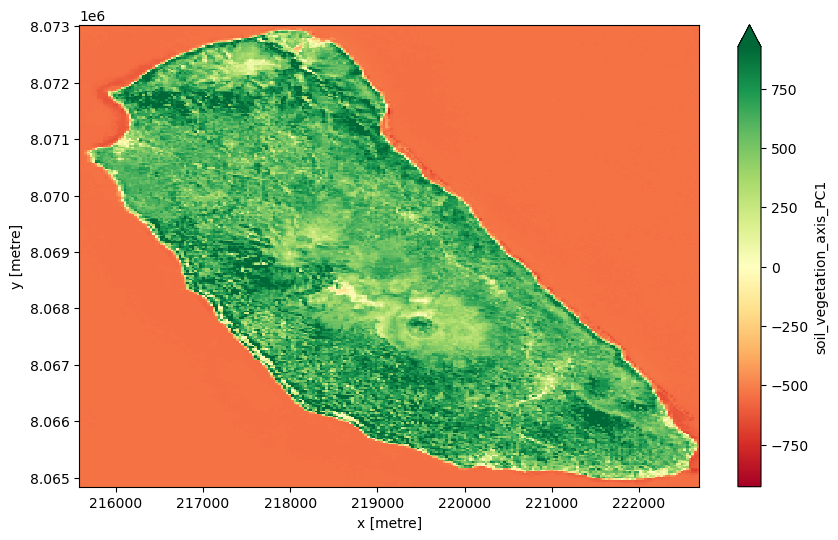

In [81]:
D, Y, X = stack.shape

# flatten spatial dims to samples: (N, D) where N = Y*X
stack_reshaped = stack.reshape(D, Y * X).T  # shape (N, D)

# Optional: sample if too large
max_samples = 10000
if stack_reshaped.shape[0] > max_samples:
    idx = np.random.choice(stack_reshaped.shape[0], max_samples, replace=False)
    pca_data = stack_reshaped[idx]
else:
    pca_data = stack_reshaped

# Run PCA
pca = PCA(n_components=2)
pca.fit(pca_data)

# Transform all pixels
pca_scores = pca.transform(stack_reshaped)

# reshape PC1 back to (Y, X)
pc1 = pca_scores[:, 0].reshape(Y, X)

# create DataArray for PC1
pc1_da = xr.DataArray(
    pc1,
    coords={
        'y': s2_data_composite['y'],
        'x': s2_data_composite['x']
    },
    dims=['y', 'x'],
    name='soil_vegetation_axis_PC1'
)

# plot
ax = pc1_da.plot(cmap='RdYlGn', robust=True, figsize=(10, 6))
#ax.set_title('Soil-Vegetation Axis (PC1)', fontsize=14)
plt.show()

### Creating a soil health score
We will created a score based on weighted inputs.

#### The weights

0.45 * ndmi_n → 45% weight to moisture

> Soil moisture is a key driver of nutrient cycling and erosion prevention.
> Given nearly equal weight with NDVI because water availability is just as important as > vegetation cover.

0.45 * ndvi_n → 45% weight to vegetation greenness

> Healthy vegetation cover prevents erosion, supports soil organisms, and maintains structure.

0.10 * (1 - bsi_n) → 10% weight to low bare soil exposure

> (1 - bsi_n) flips the bare soil index so that less bare soil = higher score.
> Low bare soil reduces erosion risk and nutrient loss.
> Smaller weight here because bare soil impact is already partially captured by NDVI and NDMI.

#### Score range:

0 → low soil health (relatively dry, sparse vegetation, high bare soil).

1 → high soil health (more moisture, greener vegetation, low bare soil exposure).

In [74]:
def calculate_soil_health_score(
    ndmi: xr.DataArray,
    ndvi: xr.DataArray,
    bsi: xr.DataArray,
    weight_ndmi: float = 0.45,
    weight_ndvi: float = 0.45,
    weight_bsi: float = 0.10
) -> xr.DataArray:
    """
    Calculate a soil health score from NDMI, NDVI, and BSI DataArrays.
    
    The score is a weighted combination of:
    - NDMI (Normalized Difference Moisture Index)
    - NDVI (Normalized Difference Vegetation Index)
    - BSI (Bare Soil Index), inverted so higher vegetation cover improves score
    
    All indices are automatically normalized to 0–1 range before weighting.

    Parameters
    ----------
    ndmi : xr.DataArray
        Raw NDMI values.
    ndvi : xr.DataArray
        Raw NDVI values.
    bsi : xr.DataArray
        Raw BSI values.
    weight_ndmi : float, optional
        Weight for NDMI in the score (default 0.45).
    weight_ndvi : float, optional
        Weight for NDVI in the score (default 0.45).
    weight_bsi : float, optional
        Weight for inverted BSI in the score (default 0.10).

    Returns
    -------
    xr.DataArray
        Soil health score scaled between 0 and 1.
    """

    def normalize(da: xr.DataArray) -> xr.DataArray:
        """Normalize a DataArray to the 0–1 range."""
        return (da - da.min()) / (da.max() - da.min())

    # Normalize each index
    ndmi_n = normalize(ndmi)
    ndvi_n = normalize(ndvi)
    bsi_n = normalize(bsi)

    # Compute the soil health score
    soil_health_score = (
        weight_ndmi * ndmi_n +
        weight_ndvi * ndvi_n +
        weight_bsi * (1 - bsi_n)  # invert BSI so high vegetation improves score
    )

    # Normalize the final score to 0–1 for consistency
    return normalize(soil_health_score)

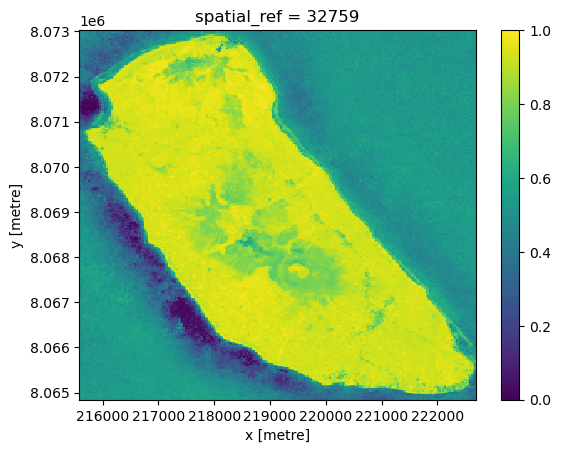

In [76]:
score_da = calculate_soil_health_score(s2_data_composite['ndmi'], 
                                       s2_data_composite['ndvi'], 
                                       s2_data_composite['bsi'])

score_da.plot()